# Identifying Fraud from Enron Data
### - Marty VanHoof

## Introduction

Founded in 1985, Enron was one of the world's major electricity, natural gas, communications and pulp and paper companies.  Enron was named "America's Most Innovative Company" for six consecutive years by *Fortune* magazine.  Much of this apparent success, though, was due to systematic and elaborate accounting fraud and corruption.  By the use of accounting loopholes, special purpose entities, and poor financial reporting, they were able to hide billions of dollars in debt from failed deals and projects.  By 2002, it had collapsed into bankruptcy, and many executives at Enron would later be indicted and some of them sent to prison.  In the resulting investigation, a large amount of typically confidential information entered into the public record.  This included a large database of emails known as the *Enron Corpus*, and also detailed financial data for top executives.  

The purpose of this project is to try to probe this financial and email data using machine learning techniques in order to attempt to identify persons of interest (POI) in the Enron scandal.  POIs are individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.  This report details the following process:
* [Data Exploration and Outlier Removal](#exploration)
* [Initial Classifier Estimation](#initial)
* [Feature Engineering](#engineering)
* [Feature Selection](#selection)
* [Algorithm Tuning](#tuning)
* [1. Naive Bayes ](#gnb)
    * [1a. Tuning Naive Bayes](#tuning_gnb)
    * [1b. Naive Bayes Results](#nb_results)
* [2. Decision Tree Classifier](#dt)
    * [2a. Tuning the Decision Tree](#tuning_dt)
    * [2b. Decision Tree Results](#dt_results)

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a id='exploration'></a>
## Data Exploration / Outlier Removal

We begin by doing some exploratory data analysis (EDA) in order to get a better understanding of the dataset and remove a few outliers.  The Enron email and financial data has been preprocessed and combined into a Python dictionary, where each key-value pair in the dictionary corresponds to one person.  The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. 

In order to make our EDA easier, we will use the Python library Pandas to first transform our Python dictionary into a Pandas dataframe.

In [2]:
# load the dictionary containing the dataset
with open('enron_dataset.pkl', 'rb') as data_file:
    data_dict = pickle.load(data_file)
    
# create a dataframe from data_dict and set the index column to employees
df = pd.DataFrame.from_dict(data_dict, orient='index')

# coerce numeric values into floats and convert NaN values to 0
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
df.fillna(0, inplace=True)

Below are the first 5 rows of our dataset.  The row observations correspond to Enron employees and the columns are the features (the email and financial information for the employee).  There were many missing values in the original financial dataset and these values were encoded in the Python dictionary as 'NaN'.  These NaN values are transformed to 0 in the dataframe.

In [3]:
df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,0.0,4175000.0,0.0,-126027.0,-3081055.0,1729541.0,...,47.0,1729541.0,2195.0,152.0,65.0,False,304805.0,1407.0,126027.0,0.0
BADUM JAMES P,0.0,0.0,178980.0,182466.0,0.0,0.0,0.0,0.0,0.0,257817.0,...,0.0,257817.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,0.0,0.0,0.0,-560222.0,-5104.0,5243487.0,...,39.0,4046157.0,29.0,864523.0,0.0,False,0.0,465.0,1757552.0,0.0
BAXTER JOHN C,267102.0,0.0,1295738.0,5634343.0,0.0,1200000.0,0.0,0.0,-1386055.0,10623258.0,...,0.0,6680544.0,0.0,2660303.0,0.0,False,1586055.0,0.0,3942714.0,0.0
BAY FRANKLIN R,239671.0,0.0,260455.0,827696.0,0.0,400000.0,0.0,-82782.0,-201641.0,63014.0,...,0.0,0.0,0.0,69.0,0.0,False,0.0,0.0,145796.0,0.0


### Some Dataset Characteristics

In [4]:
print('number of data points: ', df.shape[0])
print('number of features: ', df.shape[1])
print('number of POIs: ', df.query('poi == True').shape[0])
print('number of non POIs: ', df.query('poi == False').shape[0])

number of data points:  146
number of features:  21
number of POIs:  18
number of non POIs:  128


Below are the features with missing values (zeros) and the number of missing values for each feature.  We exclude the email addresses since they don't provide useful information and were all converted to zeros in the dataframe.

In [5]:
# print the number of missing values (zeros) for each feature except 'email_address'
zero_counts = (~df.astype(bool)).sum(axis=0)
zero_counts.drop('email_address')

salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
loan_advances                142
bonus                         64
restricted_stock_deferred    128
deferred_income               97
total_stock_value             20
expenses                      51
from_poi_to_this_person       72
exercised_stock_options       44
from_messages                 60
other                         53
from_this_person_to_poi       80
poi                          128
long_term_incentive           80
shared_receipt_with_poi       60
restricted_stock              36
director_fees                129
dtype: int64

### Outliers

Now we will remove a few outliers from the dataset.  Since the dataset is quite small, we should be conservative in removing outliers.  Also, due to the nature of the financial data, outliers such as very larges salaries, bonuses, etc, can be a signal that a particular individual is a POI, so we won't remove any of these (except for the 'TOTAL' row mentioned next). 

Statistically, an outlier is defined to be an observation that is below the first quartile $Q_1$ or above the third quartile $Q_3$ by more than 1.5 times the *interquartile range*, which is $Q_3 - Q_1$.  More specifically, let 

$$ IQR = Q_3 - Q_1 $$

be the interquartile range.  Then any data point $x$ for which

$$ x \leq Q_1 - 1.5 \cdot IQR \quad \textrm{or} \quad x \geq Q_3 + 1.5 \cdot IQR $$

can be considered an outlier.  As mentioned above, outliers of this sort can be indicative of persons of interest so we should be very careful about removing them.  In the code below, we will only look for outliers in the upper range.

In [6]:
# find the individuals with 10 or more outlier features in the upper range
Q1, Q3 = df.quantile(0.25), df.quantile(0.75) 
IQR = Q3 - Q1
outliers = df[df > Q1 + 1.5*IQR]
outlier_counts = outliers.count(axis=1).sort_values(ascending=False).head(7)
outlier_counts = outlier_counts.to_frame(name='outlier_count')
names = list(outlier_counts.index)
outlier_counts['poi'] = df.loc[names].poi
display(outlier_counts)

,outlier_count,poi
LAY KENNETH L,15,True
FREVERT MARK A,14,False
WHALLEY LAWRENCE G,13,False
SKILLING JEFFREY K,13,True
TOTAL,12,False
DELAINEY DAVID W,12,True
LAVORATO JOHN J,10,False


Using this information, we will remove Mark Frevert, Lawrence Whalley, and John Lavorato.  These people are not persons of interest even though they seem to have an unusually high number of outlier features.  

The TOTAL row is also an anomaly.  The Enron financial data comes from a PDF file called [enron61702insiderpay.pdf](enron61702insiderpay.pdf), which contains a row of totals for each financial feature, and this row was read into the Python dictionary (and thus in the dataframe) as an individual observation where it really doesn't belong.  We can get a good view of this outlier from a scatterplot of salaries and bonuses of Enron employees.  This outlier should really be removed because it will throw off our predictions when we try to fit models to the data.

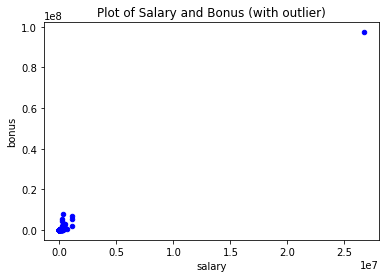

In [7]:
df.plot.scatter(x='salary', y='bonus', color='blue',
                title='Plot of Salary and Bonus (with outlier)');

### Rows containing all zeros

We should also check for observations that contain all zeros, and we can see that this person 'LOCKHART EUGENE E' doesn't have any records.  Finally, if we examine all the names in the dataframe there is one that doesn't seem to belong:  'THE TRAVEL AGENCY IN THE PARK'.  This is probably not a person, so we will remove this observation as well.

In [8]:
display(df.loc[(df == 0).all(axis=1)])
df[df.index.values == 'THE TRAVEL AGENCY IN THE PARK']

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
LOCKHART EUGENE E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0


,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
THE TRAVEL AGENCY IN THE PARK,0.0,0.0,0.0,362096.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,362096.0,0.0,False,0.0,0.0,0.0,0.0


In [9]:
# remove outliers
to_remove = ['FREVERT MARK A', 'LAVORATO JOHN J', 'WHALLEY LAWRENCE G',
             'TOTAL', 'LOCKHART EUGENE E', 'THE TRAVEL AGENCY IN THE PARK']  
df.drop(to_remove, inplace=True)
    
while False:
    to_remove = ['FREVERT MARK A', 'BAXTER JOHN C', 'LAVORATO JOHN J',
                 'WHALLEY LAWRENCE G', 'TOTAL', 'LOCKHART EUGENE E',
                 'THE TRAVEL AGENCY IN THE PARK']
    df.drop(to_remove, inplace=True)
    break

<a id='initial'></a>
## Initial Classifier Estimation

We will start by experimenting with a few different classifiers without worrying about parameter-tuning at this point.  Using the **`test_classifier()`** function in the [tester.py](tester.py) file, we can get an initial idea of the performance of each classifier before we get into tuning the parameters.  We will start by using all the features in the dataset (except email address).  The metrics that we want to optimize are the precision, recall, and the F1 score.

Consider the collection of all people in the Enron dataset who the model predicts to be a POI; then the **precision** is the proportion of those people who are actually POIs.  More precisely, if $TP$ is the number of true positives and $FP$ is the number of false positives, then

$$
\textrm{precision} = \frac{TP}{TP + FP}
$$

Now consider the collection of all people in the Enron dataset who are actually POIs; then the **recall** is the proportion of those individuals who are predicted by the model to be POIs.  If $FN$ is the number of false negatives, then

$$
\textrm{recall} = \frac{TP}{TP + FN}
$$

The **F1 score** is the harmonic mean of precision and recall and can also be interpreted as a weighted average of precision and recall

$$
\textrm{F1 score} = \frac{2}{\frac{1}{\textrm{precision}} + \frac{1}{\textrm{recall}}} = \frac{2 \cdot \textrm{precision} \cdot \textrm{recall}}{\textrm{precision} + \textrm{recall}}
$$

Note that our dataset is imbalanced, since there are 18 POI versus 128 non POI.  This means that the accuracy score (number of accurate predictions divided by the total number of data points) is not a good metric to use.

At this point we should also standardize the data since the financial and email data are measured in different units and on different scales.  We will standardize the data so that it has mean 0 and standard deviation 1. 

In [10]:
from tester import test_classifier
from feature_format import featureFormat, targetFeatureSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# convert the dataframe back into a dictionary
data_dict = df.to_dict('index')

# get a list of all the features and remove 'email_address'
features_list = list(df.columns.values)
features_list.remove('email_address')

# move 'poi' to the beginning of the list for use by the function
# targetFeatureSplit() in feature_format.py
features_list.pop(features_list.index('poi'))
features_list.insert(0, 'poi')

def clf_report(classifier, f_list, d_dict):
    ''' 
    A quick and dirty function that fits a specific classifier then uses 'test_classifier()'
    to evaluate the model's performance 
        
    Inputs:
    classifier - An sklearn classifier with the default hyperparameters
    f_list - A list of features to use
    d_dict - A data dictionary where each key-value pair corresponds to one individual
    '''
    
    # Extract features and labels from data_dict
    data_array = featureFormat(d_dict, f_list, sort_keys = True)
    labels, features = targetFeatureSplit(data_array)
    
    # Apply feature scaling
    features = scale(features)

    # Split features and labels into training and testing sets
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
    
    clf = classifier()
    clf.fit(features_train, labels_train)
    test_classifier(clf, d_dict, f_list)

### GaussianNB

In [11]:
clf_report(GaussianNB, features_list, data_dict)

Accuracy: 0.75721	Precision: 0.25186	Recall: 0.35500	F1: 0.29467	F2: 0.32813
Total predictions: 14000	True positives:  710	False positives: 2109
False negatives: 1290	True negatives: 9891



### DecisionTreeClassifier

In [12]:
clf_report(DecisionTreeClassifier, features_list, data_dict)

Accuracy: 0.82243	Precision: 0.36002	Recall: 0.31250	F1: 0.33458	F2: 0.32097
Total predictions: 14000	True positives:  625	False positives: 1111
False negatives: 1375	True negatives: 10889



### LogisticRegression

In [13]:
clf_report(LogisticRegression, features_list, data_dict)

Accuracy: 0.78636	Precision: 0.21572	Recall: 0.18800	F1: 0.20091	F2: 0.19296
Total predictions: 14000	True positives:  376	False positives: 1367
False negatives: 1624	True negatives: 10633



### KNeighborsClassifier

In [14]:
clf_report(KNeighborsClassifier, features_list, data_dict)

Accuracy: 0.87693	Precision: 0.70102	Recall: 0.24150	F1: 0.35924	F2: 0.27794
Total predictions: 14000	True positives:  483	False positives:  206
False negatives: 1517	True negatives: 11794



<a id='engineering'></a>
## Feature Engineering

The first two features we will create are called **fraction_of_emails_to_poi** and **fraction_of_emails_from_poi**.  The hypothesis here is that persons of interest may have stronger email connections between each other, ie. that POIs send emails to other POIs at a higher rate than for the general population.  The feature **fraction_of_emails_to_poi** is the proportion of all messages from a particular person that are sent to a POI, and the feature **fraction_of_emails_from_poi** is the proportion of all messages to a particular person that are sent from a POI.

If we plot the features with POI in red and non POI in blue, then there appears to be some clustering in the POIs.  Specifically, if the proportion of an individual's emails from/to a POI are below a certain threshold, then we can be confident that this individual is not a POI (the converse is not true, however).  This suggests that the above hypothesis has some merit, and we will see that these two new features will improve algorithm performance.

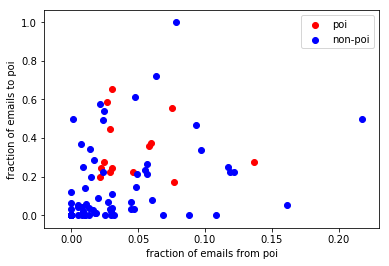

In [15]:
# create the two new features mentioned above
df['fraction_of_emails_to_poi'] = (df.from_this_person_to_poi / df.from_messages).fillna(0)
df['fraction_of_emails_from_poi'] = (df.from_poi_to_this_person / df.to_messages).fillna(0)

# split the data into poi and non-poi
df_poi = df.query('poi == True')
df_nonpoi = df.query('poi == False')

# plot the new features
plt.scatter(df_poi.fraction_of_emails_from_poi, df_poi.fraction_of_emails_to_poi,
            color='red', label='poi')
plt.scatter(df_nonpoi.fraction_of_emails_from_poi, df_nonpoi.fraction_of_emails_to_poi,
            color='blue', label='non-poi')
plt.xlabel('fraction of emails from poi')
plt.ylabel('fraction of emails to poi')
plt.legend();

Some more features we create are:
- **fraction_to_from_shared_with_poi**.  The idea here is that the 2 new features above don't incorporate all the possible emails that were shared with a POI via a third party (such as cc emails). To create this new feature, we first look at the sum total of all from messages, to messages, and messages shared with a POI.  Then we take the proportion of all these messages that are either from a POI, to a POI, or shared with a POI.
- **fraction_shared_with_poi**.
- **bonus_to_salary** and **bonus_to_total**.  Unusually large bonuses in relation to salary and total payments could indicate fraud and might make an individual more likely to be a POI.  If we look at the mean and median of these new features grouped by non-poi/poi, there seems to be a large difference.  We could test whether these differences are statistically significant (my hunch is that they are), but a good model should detect this in the data.

In [16]:
# create the new features 'fraction_to_from_shared_with_poi', 'fraction_shared_with_poi'
total = df.from_messages + df.to_messages + df.shared_receipt_with_poi
to_from_shared = df.from_poi_to_this_person + df.from_this_person_to_poi +\
                 df.shared_receipt_with_poi
df['fraction_to_from_shared_with_poi'] = (to_from_shared / total).fillna(0)
df['fraction_shared_with_poi'] = (df.shared_receipt_with_poi / df.to_messages).fillna(0)

# create the new features 'bonus_to_salary' and 'bonus_to_total'
df['bonus_to_salary'] = (df.bonus / df.salary).fillna(0)
df['bonus_to_total'] = (df.bonus / df.total_payments).fillna(0)

# look at the mean and median of these new features, grouped by non-poi/poi
display(df.groupby('poi')[['bonus_to_salary', 'bonus_to_total']].mean())
display(df.groupby('poi')[['bonus_to_salary', 'bonus_to_total']].median())

,bonus_to_salary,bonus_to_total
poi,,
False,1.577149,0.258435
True,4.776032,0.891963


,bonus_to_salary,bonus_to_total
poi,,
False,0.387364,0.087175
True,3.862706,0.535700


In [38]:
# add new features to features_list
new_features_list = features_list + ['fraction_of_emails_to_poi', 'fraction_of_emails_from_poi',
                                     'fraction_to_from_shared_with_poi', 'bonus_to_salary',
                                     'bonus_to_total', 'fraction_shared_with_poi']

# convert df with new features back into a dictionary
new_data_dict = df.to_dict('index')

<a id='selection'></a>
## Feature Selection

Univariate feature selection examines each feature individually to determine the strength of the relationship of each feature with the labels.  We can use sklearn's [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) algorithm along with [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) together in a [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to select the best features and the optimal number of features according to a certain score.  The scoring is based on a chosen univariate statistical test; the default option is `f_classif`, which performs an Analysis of Variance (ANOVA) F-test between the labels and features.  We will stick with the default option `f_classif`.  

In this project we have a binary classification problem, as we are trying to classify individuals as POI or non-POI. The scoring function `f_classif` works more generally.  Suppose we have $n$ target labels.  Then each feature can be split into $n$ groups, where observations belong to the same group if and only if they have the same class label.  The ANOVA F-test looks for a statistically significant difference among the group means by analyzing the sample variances and is based on the following:

$$ \textrm{Total Variation for each feature} = \textrm{Variation between the groups} + \textrm{Variation within the groups} $$

The more variation there is between the groups, the more likely we are to reject the null hypothesis

$$ H_0 : \mu_1 = \mu_2 = \cdots = \mu_n $$

that the population means of each group are the same.  For a given feature, let $\overline{X}_1, \ldots, \overline{X}_n \,$ be the sample means for each group, and let $X_{ij}$ be the $j^{th}$ observation in group $i$.  Thus, we can write a particular group mean $\overline{X}_i$ as

$$ 
\overline{X}_i = \frac{1}{n_i} \sum_{j=1}^{n_i} X_{ij} \,, 
$$

where $n_i$ is the number of observations in group $i$.  Let $\overline{X}$ be the *grand mean*, which is the mean of all the observations of the feature in question.  The total variation is measured by the total sum of squares

$$
\textrm{Total SS} = \sum_{i,j} (X_{ij} - \overline{X})^2 \,, 
$$

and Total SS is the sum of 2 parts

- $SSB$ (sum of squares between groups)  
- $SSW$ (sum of squares within groups)

The $SSB$ term is given by the sum of squared deviations of each group mean from the grand mean.  Because there can be a different number of observations in each group, each squared deviation must be weighted by the group size

$$
SSB = \sum_{i=1}^n n_i (\overline{X}_i - \overline{X})^2 \,.
$$

$SSW$ is given by the sum of squared deviations of each observation from its own group mean, and is found by adding the numerators of the variances in each group.  If $s_i^2$ is the variance for group $i$, then

$$ 
SSW = \sum_{i=1}^n (n_i - 1) s_i^2 \,.
$$

Then it can be shown that 

$$
\textrm{Total SS } = SSB + SSW \,.  
$$

To measure the variance between the groups and the variance within the groups, we have to divide each sum of squares term by the corresponding degrees of freedom.  Let $MSB$ denote the variance between the sample means for each group, and let $MSW$ denote the variance within each group.  These are computed as follows

$$
MSB = \frac{SSB}{n - 1} \quad \textrm{and} \quad MSW = \frac{SSW}{N - n} \,.
$$

Here, $n$ is the number of groups and $N$ is the total number of observations.  The **F-statistic** is given by

$$ F = \frac{MSB}{MSW} \,. $$

If the variation between the sample means $(MSB)$ is significantly larger than the variation within each group $(MSW)$, then this tells us that more of the variation is due to the differences in the sample means, and makes it more likely to reject the null hypothesis

$$ H_0 : \mu_1 = \mu_2 = \cdots = \mu_n $$

that the population means are the same.  Hence, a large enough value of $F$ makes it more likely that there is a statistically significant difference in at least one of the population means.  

This value of $F$ is the number that the `SelectKBest` algorithm uses to rank the features.  Features with a higher F value are considered ''better'' by the algorithm.  The code below uses the `SelectKBest` algorithm to get the best features along with the optimal number of features, and then displays the results. 

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [19]:
def get_best_features(classifier, f_list, scaling=True):

    num_features = np.arange(1, len(f_list))
    data_array = featureFormat(new_data_dict, f_list, sort_keys=True)
    labels, features = targetFeatureSplit(data_array)
    
    # create a pipeline with scaling/not scaling, feature selection and a classifier
    scaler, kbest, clf = StandardScaler(), SelectKBest(), classifier()
    if scaling:
        steps = [('scaling', scaler), ('feature_selection', kbest), ('classifier', clf)]
    else:
        steps = [('feature_selection', kbest), ('classifier', clf)]
    pipe = Pipeline(steps)
    
    # setup GridSearchCV with StratifiedShuffleSplit for cross validation
    param_grid = dict(feature_selection__k = num_features)
    cv_sss = StratifiedShuffleSplit(n_splits=100, test_size = 0.3, random_state=42)
    grid_search = GridSearchCV(pipe, param_grid, scoring='f1', n_jobs=-1, cv=cv_sss)
    grid_result = grid_search.fit(features, labels)
    
    # 'named_steps' can access the attributes/methods of a transform object in the pipeline
    selector = grid_result.best_estimator_.named_steps['feature_selection']
    features_selected = np.array(f_list[1:])[selector.get_support()]

    return list(features_selected), grid_result.best_estimator_

def display_feature_results(features_selected, estimator):
    '''
    Display the best features and ANOVA F-statistics in a Pandas dataframe.
    Also test the estimator with test_classifier()
    
    Inputs:
    features_selected - a list or array of features
    estimator - best estimator from a fitted GridSearchCV object run through a pipeline
    '''
    # first get a list of best feature/score tuples
    selector = estimator.named_steps['feature_selection']
    feature_scores = selector.scores_[selector.get_support()]
    tuples = list(zip(features_selected, feature_scores))
    
    # create a dataframe from feature/score tuples and display it
    features_df = pd.DataFrame(tuples, columns=['Feature', 'F-statistic'])
    features_df.sort_values(by=['F-statistic'], inplace=True, ascending=False)
    features_df.reset_index(drop=True, inplace=True)
    display(features_df)
    
    test_classifier(estimator, new_data_dict, ['poi']+features_selected)

### GaussianNB Best Features

In [20]:
nb_best_features, nb_model = get_best_features(GaussianNB, new_features_list, scaling=False)
display_feature_results(nb_best_features, nb_model)

,Feature,F-statistic
0,bonus,35.578815
1,exercised_stock_options,26.079999
2,total_stock_value,25.714754
3,salary,24.995563
4,bonus_to_total,20.808199
5,bonus_to_salary,16.562899
6,fraction_of_emails_to_poi,16.512128
7,deferred_income,15.717961
8,shared_receipt_with_poi,12.299520
9,from_poi_to_this_person,11.927871


Accuracy: 0.86314	Precision: 0.52602	Recall: 0.42450	F1: 0.46984	F2: 0.44154
Total predictions: 14000	True positives:  849	False positives:  765
False negatives: 1151	True negatives: 11235



### DecisionTreeClassifier Best Features

In [26]:
# Note:  in the file /Users/.../anaconda/envs/py3/lib/python3.6/site-packages/
# sklearn/feature_selection/univariate_selection.py, I had to modify the _check_params() 
# method in SelectKBest() to avoid "ValueError: k should be >=0, <= n_features"
# see https://stackoverflow.com/questions/29412348/selectkbest-based-on-estimated-amount-of-features
dt_best_features, dt_model = get_best_features(DecisionTreeClassifier, new_features_list)
display_feature_results(dt_best_features, dt_model)

,Feature,F-statistic
0,bonus,35.578815
1,exercised_stock_options,26.079999
2,total_stock_value,25.714754
3,salary,24.995563
4,bonus_to_total,20.808199
5,bonus_to_salary,16.562899
6,fraction_of_emails_to_poi,16.512128
7,deferred_income,15.717961
8,shared_receipt_with_poi,12.299520
9,from_poi_to_this_person,11.927871


Accuracy: 0.84429	Precision: 0.45268	Recall: 0.43050	F1: 0.44131	F2: 0.43476
Total predictions: 14000	True positives:  861	False positives: 1041
False negatives: 1139	True negatives: 10959



### LogisticRegression Best Features

In [43]:
lg_best_features, lg_model = get_best_features(LogisticRegression, new_features_list)
display_feature_results(lg_best_features, lg_model)

,Feature,F-statistic
0,bonus,35.578815
1,exercised_stock_options,26.079999
2,total_stock_value,25.714754
3,salary,24.995563
4,bonus_to_total,20.808199
5,bonus_to_salary,16.562899
6,fraction_of_emails_to_poi,16.512128


Accuracy: 0.84177	Precision: 0.47153	Recall: 0.23600	F1: 0.31456	F2: 0.26219
Total predictions: 13000	True positives:  472	False positives:  529
False negatives: 1528	True negatives: 10471



### KNeighborsClassifier Best Features

In [44]:
knn_best_features, knn_model = get_best_features(KNeighborsClassifier, new_features_list, scaling=False)
display_feature_results(knn_best_features, knn_model)

,Feature,F-statistic
0,bonus,35.578815
1,exercised_stock_options,26.079999


Accuracy: 0.87500	Precision: 0.73901	Recall: 0.38650	F1: 0.50755	F2: 0.42726
Total predictions: 12000	True positives:  773	False positives:  273
False negatives: 1227	True negatives: 9727



In [45]:
# need to add 'poi' back in because get_best_features() drops it from the list
nb_best_features = ['poi'] + nb_best_features
dt_best_features = ['poi'] + dt_best_features
lg_best_features = ['poi'] + lg_best_features
knn_best_features = ['poi'] + knn_best_features

<a id='tuning'></a>
## Algorithm Tuning

When we ran the above algorithms, we just used the default hyperparameters.  This is not a good strategy for getting an optimal model.  Most of these algorithms (except GaussianNB) have many hyperparameters that can be passed as arguments, and it is very unlikely that the default ones will produce an optimal model.  Hyperparameter-tuning involves trying different model hyperparameters and cross-validating them by training on a portion of the training set and using a holdout validation set to evaluate model performance.  Typically, a number of cross-validations are performed with different parts (called **folds**) of the training set, then a validation score is computed for each fold, and the final cross-validation score is the average of the scores for the different folds.  This process is called **k-fold cross-validation**.   

Rather than using trial-and-error, we will use a more systematic method to try to optimize the hyperparameters; this involves using sklearn's Pipeline and GridSearchCV classes, as we did above when we optimized the number of features for each algorithm.  A pipeline allows us to chain transformers and estimators together so that each step is performed in sequence and we don't have to worry about keeping track of the train, validation and test data during intermediate steps. GridSearchCV is a way of systematically working through multiple combinations of hyperparameters, and cross-validating in the process, in order to find the most optimal hyperparameters in a grid that we specify.

<a id='gnb'></a>
### 1. The Naive Bayes Algorithm

Naive Bayes is an algorithm used for classification problems.  Let's say we have a response variable $y$ with $k$ possible outcomes $C_1, \ldots, C_k$.  We also have features $\mathbf{x} = (x_1, x_2, \dots, x_n)$ that we want to use to try to predict the outcome (class) of $y$.  We start by trying to find the conditional probability that $y$ belongs to a class $C_j$, given the features

$$
P(C_j \,|\, \mathbf{x}) = P(C_j \,|\, x_1, x_2, \ldots, x_n)
$$

It's natural to try to use Bayes' Theorem to compute this

$$
P(C_j \,|\, \mathbf{x}) = \frac{P(\mathbf{x} \,|\, C_j) P(C_j)}{P(\mathbf{x})} 
$$

Assuming we know the values of the feature variables $x_1, \ldots, x_n$, then the joint probability $m = P(x_1, x_2, \ldots, x_n)$ is a constant.  So now we can write

$$
P(C_j \,|\, \mathbf{x}) = \frac{1}{m} P(\mathbf{x} \,|\, C_j) P(C_j) \quad (*)
$$

This is where the **Naive Bayes assumption** comes into play. We assume that $x_1, x_2, \ldots, x_n$ are [conditionally independent](https://en.wikipedia.org/wiki/Conditional_independence) given $C_j \,$:

$$
P(x_1, x_2, \ldots, x_n \,|\, C_j) = P(x_1 \,|\, C_j) P(x_2 \,|\, C_j) \cdots P(x_n \,|\, C_j) = \prod_{i=1}^k P(x_i \,|\, C_j)
$$

This assumption is "naive" because in practice it is rarely true.  However, the classifier itself turns out to work well in many situations, even if the probability estimates are inaccurate.  So now $(*)$ becomes

$$
P(C_j \,|\, \mathbf{x}) = \frac{1}{m} P(C_j) \prod_{i=1}^k P(x_i \,|\, C_j)   
$$

Finally, in order to make a prediction for what class the response variable $y$ belongs to, we pick the class $C_j$ that is most probable, ie.

$$
\textrm{prediction for y} = \underset{j \, \in \{ 1, \ldots, k \}}{\mathrm{argmax}} \, P(C_j) \prod_{i=1}^k P(x_i \,|\, C_j) 
$$

<a id="tuning_gnb"></a>
### 1a. Tuning Naive Bayes

We will start by working with the GaussianNB algorithm, as it is the most straightforward. Since GaussianNB doesn't really have any parameters to tune, we will instead try to optimize the number of principal components with principal component analysis (PCA). PCA is a way of orthogonally projecting the data to a lower dimensional space in the directions that maximize variance (or minimize information loss). Sometimes PCA will increase the performance of an algorithm and sometimes it will decrease the performance. We will use a pipeline to perform the steps: Scaling => PCA => GaussianNB.

Interestingly, the performance of GaussianNB is better when the features are not scaled, so StandardScaler is omitted below.  We also use the features `nb_best_features` that we found before.

In [52]:
from sklearn.decomposition import PCA

In [61]:
def tune_nb_clf(f_list, scaling=True):
    '''
    This function tries to optimize GaussianNB using a pipeline and GridSearchCV by
    applying the steps:  Scaling (or not) => PCA => GaussianNB
    
    Input:
    f_list - a list of features to use for the algorithm 
    '''
    data_array = featureFormat(new_data_dict, f_list, sort_keys=True)
    labels, features = targetFeatureSplit(data_array)
    labels, features = np.array(labels), np.array(features)
    
    # create a pipeline with scaling/no scaling, pca, and GaussianNB
    scaler, pca, nb_clf = StandardScaler(), PCA(), GaussianNB()
    steps = [('pca', pca), ('nb', nb_clf)]
    if scaling:
        steps = [('scaling', scaler)] + steps
    pipe = Pipeline(steps)
    
    # hyperparameters and parameter grid for grid search
    num_components = range(1, len(f_list))
    whiten = [True, False]
    priors = [(0.9,0.1), (0.87,0.13), (0.8,0.2), (0.7,0.3)]
    
    param_grid = dict(pca__n_components=num_components,
                      pca__whiten=whiten,
                      nb__priors=priors)
    
    # setup GridSearchCV with StratifiedShuffleSplit for cross validation
    cv_sss = StratifiedShuffleSplit(n_splits=100, test_size = 0.3, random_state=42)
    grid_search = GridSearchCV(pipe, param_grid, scoring='f1', n_jobs=-1, cv=cv_sss)
    grid_search.fit(features, labels)

    # the optimal model from GridSearchCV is
    nb_clf = grid_search.best_estimator_
    
    return nb_clf, param_grid

<a id="nb_results"></a>
### 1b. Naive Bayes Results

In [63]:
def display_model_results(estimator, param_grid, f_list):
    '''
    Display the results from tuning a machine learning classifier.  Shows the
    optimal hyperparameters resulting from GridSearch and also tests the classifier
    using the test_classfier() function.
    
    Inputs:
    estimator - best estimator from a fitted GridSearchCV object run through a pipeline
    param_grid - parameter grid used for the grid search
    f_list - features to use for the algorithm
    '''
    
    best_parameters = estimator.get_params()
    tuples = []
    for parameter in param_grid.keys():
        tuples.append((parameter, best_parameters[parameter]))
    
    parameters_df = pd.DataFrame(tuples, columns=['hyperparameter', 'value'])
    display(parameters_df)
    
    test_classifier(estimator, new_data_dict, f_list)
    
nb_clf, nb_grid = tune_nb_clf(nb_best_features, scaling=False)
display_model_results(nb_clf, nb_grid, nb_best_features)

,hyperparameter,value
0,pca__n_components,4
1,pca__whiten,True
2,nb__priors,"(0.7, 0.3)"


Accuracy: 0.85686	Precision: 0.49893	Recall: 0.46750	F1: 0.48271	F2: 0.47347
Total predictions: 14000	True positives:  935	False positives:  939
False negatives: 1065	True negatives: 11061



<a id="dt"></a>
### 2. The Decision Tree Algorithm

...

<a id="tuning_dt"></a>
### 2a. Tuning the Decision Tree

...

In [88]:
from sklearn.preprocessing import MinMaxScaler

def tune_dt_clf(f_list, scaling=True):
    '''
    '''
    data_array = featureFormat(new_data_dict, f_list, sort_keys=True)
    labels, features = targetFeatureSplit(data_array)
    labels, features = np.array(labels), np.array(features)
    
    # pipeline
    scaler, dt_clf = MinMaxScaler(), DecisionTreeClassifier()
    steps = [('dt', dt_clf)]
    if scaling:
        steps = [('scaling', scaler)] + steps
    pipe = Pipeline(steps)
    
    # hyperparameters and parameter grid for grid search
    criterion = ['gini', 'entropy']
    splitter = ['best', 'random']
    max_depth = range(30, 80, 5)
    min_samples_split = [2,3,4]
    min_samples_leaf = [1,2,3]
    class_weight = ['balanced']
    
    param_grid = dict(dt__criterion=criterion, dt__splitter=splitter,
                      dt__max_depth=max_depth, dt__min_samples_split=min_samples_split,
                      dt__min_samples_leaf=min_samples_leaf, dt__class_weight=class_weight)
    
    # setup GridSearchCV with StratifiedShuffleSplit for cross validation
    cv_sss = StratifiedShuffleSplit(n_splits=100, test_size = 0.3, random_state=42)
    grid_search = GridSearchCV(pipe, param_grid, scoring='f1', n_jobs=-1, cv=cv_sss)
    grid_search.fit(features, labels)
    
    # the optimal model from GridSearchCV is
    dt_clf = grid_search.best_estimator_
    
    return dt_clf, param_grid
  

In [89]:
dt_clf, dt_grid = tune_dt_clf(dt_best_features)
display_model_results(dt_clf, dt_grid, dt_best_features)

,hyperparameter,value
0,dt__criterion,gini
1,dt__splitter,best
2,dt__max_depth,55
3,dt__min_samples_split,3
4,dt__min_samples_leaf,3
5,dt__class_weight,balanced


Accuracy: 0.82014	Precision: 0.41315	Recall: 0.61600	F1: 0.49458	F2: 0.56092
Total predictions: 14000	True positives: 1232	False positives: 1750
False negatives:  768	True negatives: 10250

